# 0. References

**TODO**: There has been extensive work done on vibrissae movement and some work in conversion from the movement to neural signal in receptor neurons. Do a literature review on the works of following people (maybe not inclusive)
* http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002591
* https://phdcns.sissa.it/faculty/mathew-diamond
* https://neurophysics.ucsd.edu/journal_articles.php
* http://www.mccormick.northwestern.edu/research-faculty/directory/profiles/hartmann-mitra.html
* http://www.cell.com/neuron/pdf/S0896-6273(04)00198-9.pdf
* http://www.jneurosci.org/content/jneuro/23/16/6499.full.pdf
* http://www.scholarpedia.org/article/Vibrissa_mechanical_properties

# 1. Texture

We are going to represent a texture as a 1D pattern, consisting of blocks of varying height and length with varying intervals

In [1]:
import random
import numpy as np
import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

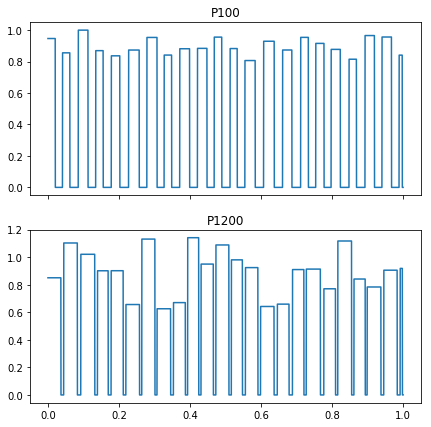

In [2]:
def blockTex(lExtent, hExtent, iExtent):
    rez = []
    pos = 0
    while pos < 1:
        L = random.uniform(lExtent[0], lExtent[1])
        H = random.uniform(hExtent[0], hExtent[1])
        I = random.uniform(iExtent[0], iExtent[1])
        
        rez.append([np.array([pos, H]), np.array([pos + L, H])])
        pos += L + I
    
    indLast = len(rez)-1
    if rez[indLast][1][0] > 1:
        rez[indLast][1][0] = 1
    
    return rez


def blockTex2Plot(tex, nPoints):
    rez = []

    H = tex[0][0][1]
    L = tex[0][1][0]-tex[0][0][0]
    xend = tex[0][1][0]
    
    rez += [H]*int(L*nPoints)
    
    for i in range(1, len(tex)):
        H = tex[i][0][1]
        L = tex[i][1][0] - tex[i][0][0]
        I = tex[i][0][0] - xend
        
        rez += [0]*int(I*nPoints)
        rez += [H]*int(L*nPoints)
        
        xend = tex[i][1][0]
        
    if len(rez) < nPoints:
        rez += [0] * (nPoints - len(rez))
    
    return rez

nPoints = 10000
textureX = np.linspace(0, 1, nPoints)
P100  = blockTex([0.02, 0.03], [0.8, 1.0], [0.02,  0.025])
P1200 = blockTex([0.03, 0.04], [0.6, 1.2], [0.005, 0.010])
P100y = blockTex2Plot(P100, nPoints)
P1200y = blockTex2Plot(P1200, nPoints)

fig, axs = plt.subplots(nrows=2, figsize=(7, 7), sharex=True)
axs[0].plot(textureX, P100y)
axs[0].set_title('P100')
axs[1].plot(textureX, P1200y)
axs[1].set_title('P1200')
plt.show()

# 2. Whisker Physics

As a first approximation, we will assume that the (effective) base of the whisker will be moving over the texture at a constant distance $H_0$, with constant tangential velocity $v_0$. We will assume that the whisker is a solid rod of length $L_0$, that can only bend with respect to its (effective) base, and that it will experience elastic restoring force proportional to the bending angle. The behaviour of the whisker can be subdivided into 3 distincti phases

$x_{base}(t) = x_{base}(t - \Delta t) + v_0 \Delta t$

**Stick phase**: During this time, the whisker is stuck to the front edge of a feature at position $x_f$ and height $h_f$. It slides along it, increasing the bending angle until the critical angle, when it slips
<ul>
    <li> $L(t) = \sqrt{(x_{base}(t) - x_f)^2 + (H_0 - h_f)^2}$
    <li> $\alpha(t) = \tan^{-1} \bigl [ \frac{x_{base} - x_f}{H_0 - h_f} \bigr ]$
    <li> $\alpha(t) = \alpha(t - \Delta t) + \frac{(H - h_f)}{L(t)^2}v_0 \Delta t$
    <li> The slip happens if $L(t) \geq L_0$
    <ul>
    <li> Phase $\rightarrow$ Slip Phase
    <li> $(x_{tip}, y_{tip}) = (x_f, h_f)$
    </ul>
</ul>
**Slip phase**: During this phase, the whisker slides along the feature with the same velocity $v_0$ as its base. The angle and thus the tip height $y_{tip}$ do not change. Transition to spring phase happens when the feature ends.
<ul>
    <li> $\dot{\alpha}$ = 0
    <li> $x_{tip}(t) = x_{tip}(t - \Delta t) + v_0 \Delta t$
    <li> If texture ends, s.t. $Tex(x_{tip} == 0)$, then
    <ul>
        <li> Phase $\rightarrow$ Spring Phase
    </ul>
</ul>
**Spring phase** During this phase, the whisker springs back at an accelerated pace, until it hits the next feature and transitions either to Stick phase or directly to Slip phase. When the whisker is not touching anything, it behaves as a damped harmonic oscillator. Note that we re most likely interested in underdamping, which means that $\zeta = \frac{c}{2\sqrt{k}} \in (0, 1)$
<ul>
    <li> $\ddot{\alpha}(t) = - k \alpha(t) - c \dot{\alpha}(t)$
    <li> $\dot{\alpha}(t) = \dot{\alpha}(t-\Delta t)(1 - c\Delta t) - \alpha(t-\Delta t) k \Delta t$
    <li> $\alpha(t) = \alpha(t - \Delta t) + \dot{\alpha}(t) \Delta t$
    <li> If collides with something
    <ul>
        <li> $(x_f, h_f) = $ IntersectionPoint
        <li> If intersect at the start:  Phase $\rightarrow$ Stick Phase
        <li> If intersect in the middle: Phase $\rightarrow$ Slip Phase
    </ul>
</ul>

In [3]:
# First we would like to code up an edge intersection algorhithm
# To determine collisions between 

def edgeIntersect1D(x11, x12, x21, x22):
    # Ensure the coordinates are ordered
    e1 = sorted([x11, x12])
    e2 = sorted([x11, x12])

    # Check if end of one is past the beginning of the other
    if (e1[0] > e2[1]) or (e2[0] > e1[1]):
        return False
    else:
        return True

    
def edgeIntersect2D(p1, p2, q1, q2):
    # First check if boxes containing each edge intersect, as this is much cheaper
    if not edgeIntersect1D(p1[0], p2[0], q1[0], q2[0]):
        return None
    elif not edgeIntersect1D(p1[1], p2[1], q1[1], q2[1]):
        return None
    else:
        # If the edges are sufficiently close to each other, worth to check if they intersect
        # q1 - p1 = (p2 - p1)t - (q2 - q1)tau
        b = q1 - p1
        dp = p2 - p1
        dq = q2 - q1
        M = np.column_stack((dp, -dq))
        t = np.linalg.solve(M, b)
        if (t[0] >= 0) and (t[0] <= 1) and (t[1] >= 0) and (t[1] <= 1):
            return p1 + dp * t[0]
        else:
            return None
        
p1 = np.array([1, 1])
p2 = np.array([3, 3])
q1 = np.array([2, 0])
q2 = np.array([1, 1])
print(edgeIntersect2D(p1, p2, q1, q2))

[ 1.  1.]


Now lets perform the simulation

step 443 found intersection 1
step 6303 found intersection 6
step 8734 found intersection 9
step 10088 found intersection 11
step 10491 found intersection 19


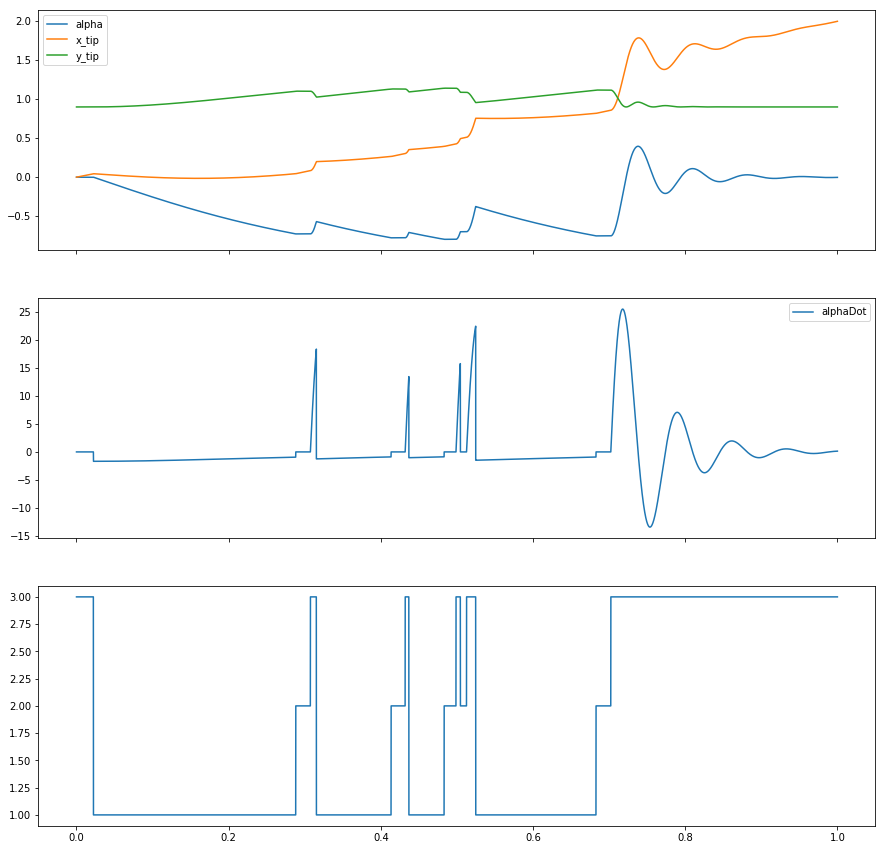

In [10]:
v0 = 1.0
dt = 0.0001
H0 = 1.7
L0 = 0.8
alpha = 0.0
alphaDot = 0.0
k_spring = 2000.0
c_spring_critical = 2 * np.sqrt(k_spring)
c_spring = 0.2 * c_spring_critical
p_base = np.array([0.0, H0])
p_tip  = np.array([0.0, H0-L0])
tex = np.copy(P1200)

# Check if initially the whisker is intersecting the first feature
#print("Testing initial intersection for", p_base, p_tip, tex[0][0], tex[0][1])
p_intersect = edgeIntersect2D(p_base, p_tip, tex[0][0], tex[0][1])

if p_intersect is None:
    iFeature = -1
    state = "spring"
else:
    print('step', 0, 'intersection', p_intersect)
    
    iFeature = 0
    state = "stick"
    
nTimeSteps = 2 * int(1.0 / dt)
timesteps = np.linspace(0, 1.0, nTimeSteps)

state2num = {"stick" : 1, "slip" : 2, "spring" : 3}

alphaHistory = [alpha]
alphaDotHistory = [alphaDot]
baseXHistory = [p_base[0]]
baseYHistory = [p_base[1]]
tipXHistory = [p_tip[0]]
tipYHistory = [p_tip[1]]
stateHistory = [state2num[state]]
    
for i in range(nTimeSteps-1):
    p_base[0] += v0 * dt
    
    #print("step", i, "state", state)
    
    if state == "stick":
        dist_x = p_base[0] - tex[iFeature][0][0]
        dist_y = p_base[1] - tex[iFeature][0][1]
        
        L = np.sqrt(dist_x**2 + dist_y**2)
        alphaDot = -dist_y * v0 / L**2
        alpha += alphaDot * dt
        #alpha = np.arctan(dist_x / dist_y)
        p_tip = p_base + L0 * np.array([np.sin(alpha), -np.cos(alpha)])
        
        if L >= L0:
            state = "slip"
            alphaDot = 0
            p_tip = tex[iFeature][0]
        
    elif state == "slip":
        p_tip[0] += v0 * dt
        if p_tip[0] >= tex[iFeature][1][0]:
            state = "spring"
    else:
        alphaDot -= (alphaDot * c_spring + alpha * k_spring) * dt
        alpha += alphaDot * dt
        p_tip = p_base + L0 * np.array([np.sin(alpha), -np.cos(alpha)])
    
    # Check for collisions in all stages
    for iF in range(iFeature+1, len(tex)):
        p_intersect = edgeIntersect2D(p_tip, p_base, tex[iF][0], tex[iF][1])
        if p_intersect is not None:
            print("step", i, "found intersection", iF)

            iFeature = iF
            if np.linalg.norm(p_intersect - tex[iF][0]) < 0.01:
                state = "stick"
            else:
                p_tip = p_intersect
                alphaDot = 0
                state = "slip"

            break;
                
    alphaHistory.append(alpha)
    alphaDotHistory.append(alphaDot)
    tipXHistory.append(p_tip[0])
    tipYHistory.append(p_tip[1])
    baseXHistory.append(p_base[0])
    baseYHistory.append(p_base[1])
    stateHistory.append(state2num[state])

    
fig, axs = plt.subplots(nrows=3, figsize=(15, 15), sharex=True)
axs[0].plot(timesteps, alphaHistory, label="alpha")
axs[0].plot(timesteps, tipXHistory, label="x_tip")
axs[0].plot(timesteps, tipYHistory, label="y_tip")
axs[0].legend()
axs[1].plot(timesteps, alphaDotHistory, label="alphaDot")
axs[1].legend()
axs[2].plot(timesteps, stateHistory)
plt.show()

We write the whisker to video, to see how it works in practice

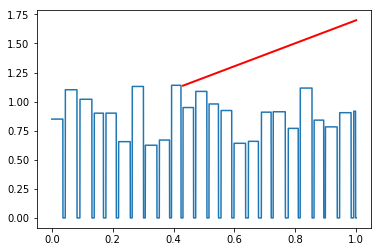

In [8]:
fig = plt.figure()
texPlt, = plt.plot(textureX,P1200y)
linePlt, = plt.plot([baseXHistory[10000], tipXHistory[10000]], [baseYHistory[10000], tipYHistory[10000]], 'r-', lw=2)
plt.show()


In [6]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=100, metadata=metadata)

#fig = plt.figure()
my_dpi = 100
fig = plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
texPlt, = plt.plot(textureX,P1200y)
linePlt, = plt.plot([], [], 'r-', lw=2)

minX = np.min([np.min(textureX), np.min(baseXHistory), np.min(tipXHistory)])
maxX = np.max([np.max(textureX), np.max(baseXHistory), np.max(tipXHistory)])
minY = np.min([np.min(P1200y), np.min(baseYHistory), np.min(tipYHistory)])
maxY = np.max([np.max(P1200y), np.max(baseYHistory), np.max(tipYHistory)])

print(len(textureX))
print(fig.get_size_inches())
print(fig.dpi)

    plt.xlim(minX, maxX)
plt.ylim(minY, maxY)

with writer.saving(fig, "writer_test.mp4", my_dpi):
    for i in range(0, nTimeSteps, 10):
        if i % 100 == 0:
            print("writing frame", i)
            
        linePlt.set_data([baseXHistory[i], tipXHistory[i]], [baseYHistory[i], tipYHistory[i]])
        writer.grab_frame()

10000
[ 8.  8.]
100
writing frame 0
writing frame 100
writing frame 200
writing frame 300
writing frame 400
writing frame 500
writing frame 600
writing frame 700
writing frame 800
writing frame 900
writing frame 1000
writing frame 1100
writing frame 1200
writing frame 1300
writing frame 1400
writing frame 1500
writing frame 1600
writing frame 1700
writing frame 1800
writing frame 1900
writing frame 2000
writing frame 2100
writing frame 2200
writing frame 2300
writing frame 2400
writing frame 2500
writing frame 2600
writing frame 2700
writing frame 2800
writing frame 2900
writing frame 3000
writing frame 3100
writing frame 3200
writing frame 3300
writing frame 3400
writing frame 3500
writing frame 3600
writing frame 3700
writing frame 3800
writing frame 3900
writing frame 4000
writing frame 4100
writing frame 4200
writing frame 4300
writing frame 4400
writing frame 4500
writing frame 4600
writing frame 4700
writing frame 4800
writing frame 4900
writing frame 5000
writing frame 5100
writ

# 3. Whisking to Neural Activity

By Newton's 3rd law, the force applied to the tip of the whisker translates directly to the base of the whisker. Let's define some sensory neurons. First type will be a stochastic neuron that responds only to positive force, and whose probability of spiking is proportional to the force. Also, a small bias can be introduced to account for spikes due to pure noise. Note that the negative force would influence another neuron on the opposite side of the whisker base. Thus, the equation for the probability of a spike happening within a small time interval is given by

$dP_{spike}(t) = (\alpha F_{>0}(t) + \beta) dt$

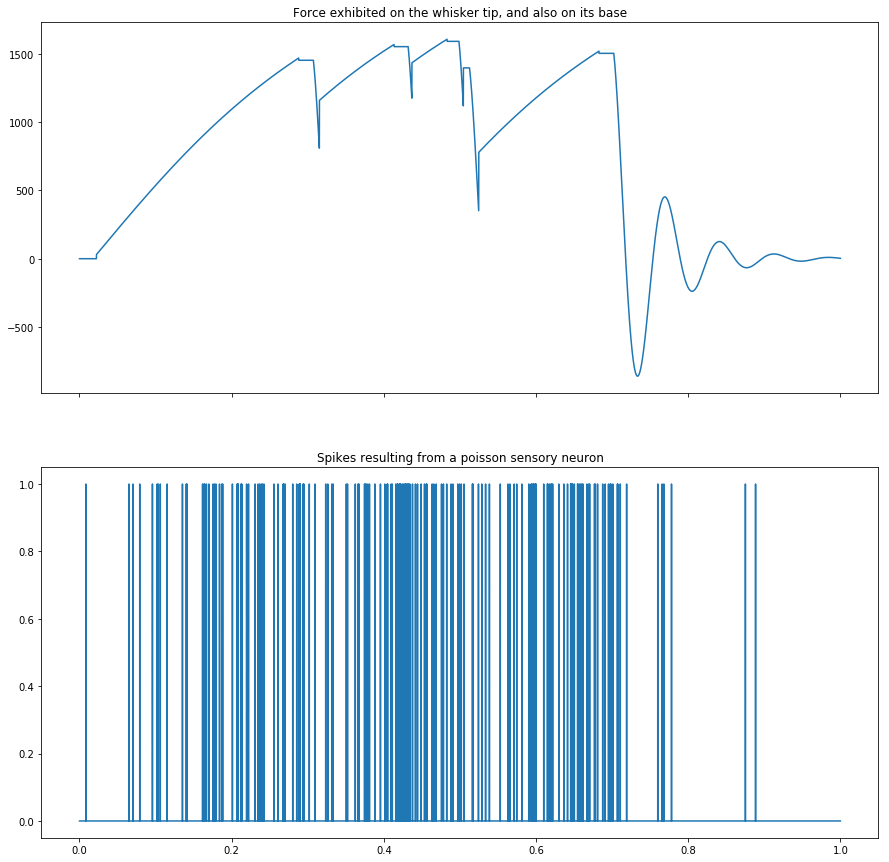

In [41]:
alphaForce = 0.1
betaForce = 100 * alphaForce

forceHistory = -k_spring * np.array(alphaHistory) - c_spring * np.array(alphaDotHistory)
forceHistoryPositive = np.copy(forceHistory)
forceHistoryPositive[forceHistoryPositive < 0] = 0

forceNeuronSpikes = np.zeros(nTimeSteps-1)
for i in range(nTimeSteps-1):
    pSpike = (alphaForce * forceHistoryPositive[i] + betaForce) * dt
    forceNeuronSpikes[i] = np.random.choice([0, 1], p=[1.0 - pSpike, pSpike])

fig, ax = plt.subplots(nrows=2, figsize=(15, 15), sharex=True)
ax[0].plot(timesteps, forceHistory)
ax[0].set_title("Force exhibited on the whisker tip, and also on its base")
ax[1].plot(timesteps[:-1], forceNeuronSpikes)
ax[1].set_title("Spikes resulting from a poisson sensory neuron")
plt.show()

Another type of neurons could be shock neurons. In this case, the neuron would produce a burst of spikes every time there is a rapid change of force and velocity. We shall first calculate the shocks by taking instantainous derivatives, then convolve them with an exponential tail to model gradual relaxation of the shocked neuron, and finally model the neuron as a stochastic neuron, same as in the previous case.

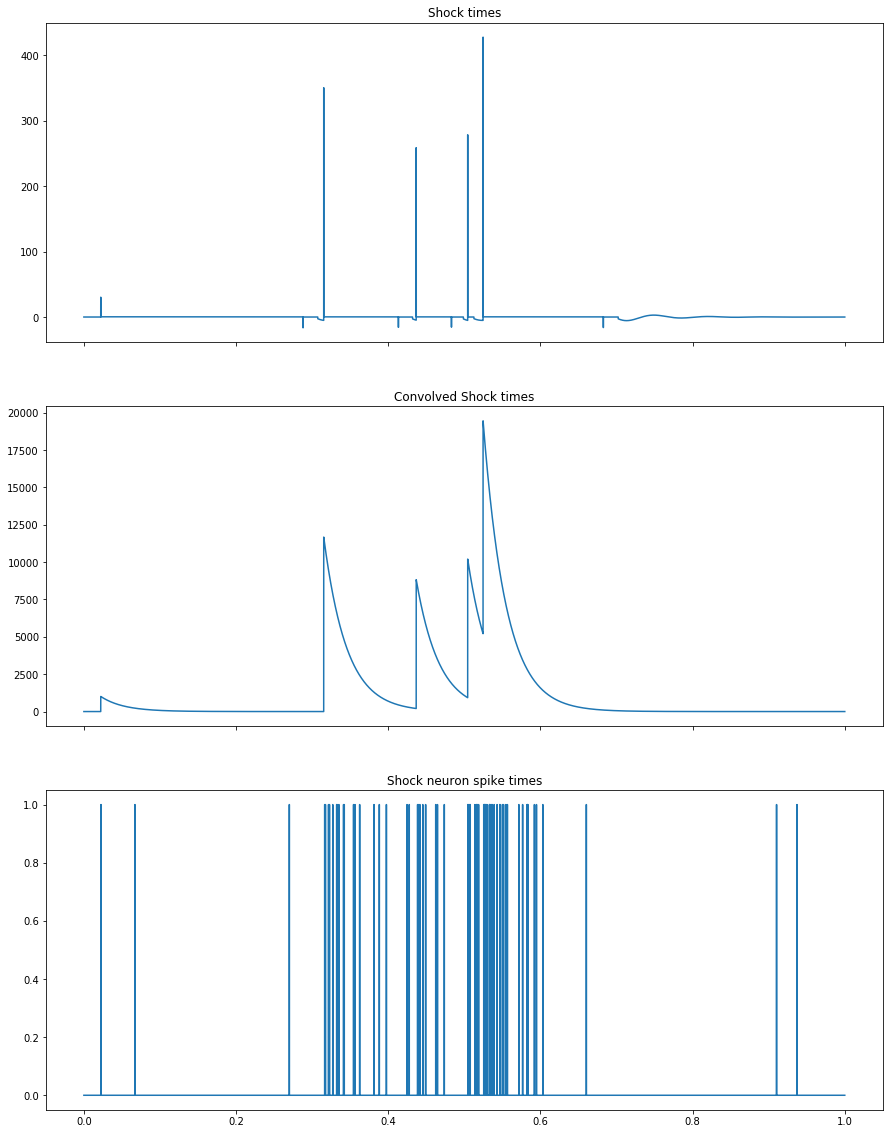

In [58]:
shockHistory = forceHistory[1:] - forceHistory[:-1]
shockHistoryPositive = np.copy(shockHistory)
shockHistoryPositive[shockHistoryPositive < 10] = 0

tau = 0.03
tail = np.exp(-timesteps[:-1]/tau)/tau
shockTail = np.convolve(shockHistoryPositive, tail)[:nTimeSteps-1]

alphaShock = 0.03
betaShock = 100 * alphaShock

shockNeuronSpikes = np.zeros(nTimeSteps-1)
for i in range(nTimeSteps-1):
    pSpike = (alphaShock * shockTail[i] + betaShock) * dt
    shockNeuronSpikes[i] = np.random.choice([0, 1], p=[1.0 - pSpike, pSpike])


fig, ax = plt.subplots(nrows=3, figsize=(15, 20), sharex=True)
ax[0].plot(timesteps[:-1], shockHistory)
ax[0].set_title("Shock times")
ax[1].plot(timesteps[:-1], shockTail)
ax[1].set_title("Convolved Shock times")
ax[2].plot(timesteps[:-1], shockNeuronSpikes)
ax[2].set_title("Shock neuron spike times")
plt.show()